# Telco Churn Report

## Acquire

### First lets bring in our libraries

In [1]:
import numpy as np
import pandas as pd
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from acquire import get_telco_data
from prepare import prep_telco_data

#Tells pandas to show all columns when displaying the DataFrame
pd.set_option('display.max_columns', None)

# Change some matplotlib setting so plots look better
plt.rc('figure', figsize=(13, 10))
plt.rc('font', size=13)

import warnings
warnings.filterwarnings("ignore")

### Now let's bring get the telco data and take a peek at it

In [2]:
telco = get_telco_data()
telco

,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,internet_service_type_id,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,contract_type_id,paperless_billing,payment_type_id,monthly_charges,total_charges,churn,contract_type,internet_service_type,payment_type
0,0003-MKNFE,Male,0,No,No,9,Yes,Yes,1,No,No,No,No,No,Yes,1,No,2,59.90,542.4,No,Month-to-month,DSL,Mailed check
1,0013-MHZWF,Female,0,No,Yes,9,Yes,No,1,No,No,No,Yes,Yes,Yes,1,Yes,4,69.40,571.45,No,Month-to-month,DSL,Credit card (automatic)
2,0015-UOCOJ,Female,1,No,No,7,Yes,No,1,Yes,No,No,No,No,No,1,Yes,1,48.20,340.35,No,Month-to-month,DSL,Electronic check
3,0023-HGHWL,Male,1,No,No,1,No,No phone service,1,No,No,No,No,No,No,1,Yes,1,25.10,25.1,Yes,Month-to-month,DSL,Electronic check
4,0032-PGELS,Female,0,Yes,Yes,1,No,No phone service,1,Yes,No,No,No,No,No,1,No,3,30.50,30.5,Yes,Month-to-month,DSL,Bank transfer (automatic)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,9950-MTGYX,Male,0,Yes,Yes,28,Yes,No,3,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,3,Yes,4,20.30,487.95,No,Two year,None,Credit card (automatic)
7039,9953-ZMKSM,Male,0,No,No,63,Yes,Yes,3,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,3,No,2,25.25,1559.3,No,Two year,None,Mailed check
7040,9964-WBQDJ,Female,0,Yes,No,71,Yes,Yes,3,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,3,Yes,4,24.40,1725.4,No,Two year,None,Credit card (automatic)
7041,9972-EWRJS,Female,0,Yes,Yes,67,Yes,No,3,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,3,Yes,3,19.25,1372.9,No,Two year,None,Bank transfer (automatic)


In [3]:
telco.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 24 columns):
customer_id                 7043 non-null object
gender                      7043 non-null object
senior_citizen              7043 non-null int64
partner                     7043 non-null object
dependents                  7043 non-null object
tenure                      7043 non-null int64
phone_service               7043 non-null object
multiple_lines              7043 non-null object
internet_service_type_id    7043 non-null int64
online_security             7043 non-null object
online_backup               7043 non-null object
device_protection           7043 non-null object
tech_support                7043 non-null object
streaming_tv                7043 non-null object
streaming_movies            7043 non-null object
contract_type_id            7043 non-null int64
paperless_billing           7043 non-null object
payment_type_id             7043 non-null int64
monthly_charges 

* Takeaways
    * `total_charges` is an object so we will have to see if there is a string value that caused it to become an object.
    * Several of these variables are string so we will need to find away to convert them to ints so that we can use them in modeling.
    * There appears to be no null values but we will have to dig into the columns to make sure that this is true

### Let's look at the `total_charges` and see if there is a string that is causing an issue

In [4]:
telco.total_charges.value_counts()

           11
20.2       11
19.75       9
19.9        8
19.65       8
           ..
1212.25     1
5124.55     1
7031.3      1
6581.9      1
2979.3      1
Name: total_charges, Length: 6531, dtype: int64

There is a blank value for 11 of the values so we will need to make sure to change those in the preparation stage.

### Let's take a look at the distribution of tenure

Text(0, 0.5, 'Count')

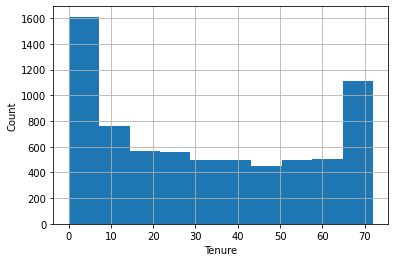

In [5]:
telco.tenure.hist()
plt.xlabel("Tenure")
plt.ylabel("Count")

We can see that our most common tenures are our lowest months and highest months.

## Preparation

### First, let's create a column called `tenure_years` that tells how many years we have had the customer.

In [6]:
telco['tenure_years'] = telco.tenure // 12
telco.tenure_years

0       0
1       0
2       0
3       0
4       0
       ..
7038    2
7039    5
7040    5
7041    5
7042    3
Name: tenure_years, Length: 7043, dtype: int64

### Now let's split the data

In [7]:
train, test = train_test_split(telco, train_size=.7, random_state=13)
train, val = train_test_split(train, train_size=.7, random_state=13)
print(f'There are {train.shape[0]} rows in train')
print(f'There are {val.shape[0]} rows in val')
print(f'There are {test.shape[0]} rows in test')

There are 3451 rows in train
There are 1479 rows in val
There are 2113 rows in test


### Now let's see about fixing that `total_charges` column

We saw that it was filled with some empty space so let's strip that away and see how many empty string there are.

In [8]:
(train.total_charges.str.strip() == '').sum()

3

So their are three of them, let's see if there appears to be a reason that they are blank.

In [9]:
# Look at specific columns where the blank strings exist
train[train.total_charges.str.strip() == ''][['tenure', 'monthly_charges', 'total_charges', 'churn']]

,tenure,monthly_charges,total_charges,churn
6569,0,20.00,,No
2048,0,52.55,,No
6686,0,25.75,,No


So it looks like the customers haven't even completed one month but they haven't churned so we will just remove them from the data. 

In [10]:
#Replace the blank spaces with NaN
train.total_charges = train.total_charges.str.strip().replace('', np.nan)
#Change total_charges to a float
train.total_charges = train.total_charges.astype('float')
#Remove Nans
train = train.dropna()

### Lets make sure that the empty string are gone.

In [11]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3448 entries, 2614 to 3916
Data columns (total 25 columns):
customer_id                 3448 non-null object
gender                      3448 non-null object
senior_citizen              3448 non-null int64
partner                     3448 non-null object
dependents                  3448 non-null object
tenure                      3448 non-null int64
phone_service               3448 non-null object
multiple_lines              3448 non-null object
internet_service_type_id    3448 non-null int64
online_security             3448 non-null object
online_backup               3448 non-null object
device_protection           3448 non-null object
tech_support                3448 non-null object
streaming_tv                3448 non-null object
streaming_movies            3448 non-null object
contract_type_id            3448 non-null int64
paperless_billing           3448 non-null object
payment_type_id             3448 non-null int64
monthly_charg

# TODO: **Explain the encoding process**

### Great let's put this all into some functions in `prepare.py` and test it out.

In [12]:
train, val, test = prep_telco_data(get_telco_data())
train

,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,internet_service_type_id,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,contract_type_id,paperless_billing,payment_type_id,monthly_charges,total_charges,churn,contract_type,internet_service_type,payment_type,tenure_years,gender_encoded,senior_citizen_encoded,partner_encoded,dependents_encoded,phone_service_encoded,paperless_billing_encoded,churn_encoded
2614,0899-LIIBW,Male,0,Yes,No,34,Yes,Yes,2,No,No,Yes,No,Yes,Yes,1,No,1,100.85,3527.30,No,Month-to-month,Fiber optic,Electronic check,2,1,0,1,0,1,0,0
4688,2480-EJWYP,Female,1,Yes,No,58,Yes,Yes,2,No,Yes,No,No,Yes,Yes,2,Yes,3,97.80,5458.80,No,One year,Fiber optic,Bank transfer (automatic),4,0,1,1,0,1,1,0
4640,1591-MQJTP,Male,1,Yes,No,51,Yes,Yes,2,Yes,No,Yes,No,No,Yes,2,Yes,3,93.65,4839.15,No,One year,Fiber optic,Bank transfer (automatic),4,1,1,1,0,1,1,0
6557,2333-KWEWW,Male,0,No,No,18,Yes,No,3,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,3,No,4,20.05,388.60,No,Two year,None,Credit card (automatic),1,1,0,0,0,1,0,0
4576,0512-FLFDW,Female,1,Yes,No,60,Yes,Yes,2,No,No,Yes,No,Yes,Yes,2,Yes,4,100.50,6029.00,No,One year,Fiber optic,Credit card (automatic),5,0,1,1,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1109,8967-SZQAS,Female,0,No,No,14,Yes,No,1,No,Yes,No,No,No,No,1,No,1,50.45,765.45,No,Month-to-month,DSL,Electronic check,1,0,0,0,0,1,0,0
2598,0818-OCPZO,Male,1,No,No,27,Yes,Yes,2,No,Yes,No,No,No,No,1,Yes,1,81.45,2122.05,Yes,Month-to-month,Fiber optic,Electronic check,2,1,1,0,0,1,1,1
565,4608-LCIMN,Male,0,Yes,Yes,8,Yes,No,1,No,No,No,No,No,No,1,No,3,44.65,369.15,No,Month-to-month,DSL,Bank transfer (automatic),0,1,0,1,1,1,0,0
4542,9957-YODKZ,Male,1,Yes,No,6,Yes,Yes,2,No,No,Yes,No,No,No,1,Yes,1,80.80,457.10,No,Month-to-month,Fiber optic,Electronic check,0,1,1,1,0,1,1,0


## Exploration

### Let's investigate if a group is identified by tenure, is there a cohort or cohorts who have a higher rate of churn than other cohorts?

Let's use tenure_years for this so that we get a more categorical look at the tenures. We will also use a $\chi^2$ contingency test to see if churn is independent of tenure

##### $\chi^2$ Test

$H_0$: Churn and years of tenure are independent of each other.

$H_a$: Churn and years of tenure are not independent of each other.

$\alpha$ = 0.05

In [13]:
churn_by_tenure_years = pd.crosstab(train.tenure_years, train.churn)

chi2_stat, p, degf, expected = stats.chi2_contingency(churn_by_tenure_years)

alpha = 0.05

if p < alpha:
    print('p is less than alpha; Reject the null hypothesis')
    print(f'{p} < {alpha}')
else:
    print('p is greater than alpha; Fail to reject the null hypothesis')
    print(f'{p} > {alpha}')

p is less than alpha; Reject the null hypothesis
3.351158518758565e-96 < 0.05


So we can reject the null hypothesis, meaning that churn is not independent of years of tenure.

#### Let's look at a plot of years of tenure against churn rate

Text(0.5, 1.0, 'Do certain cohorts of tenure have a higher churn rate?')

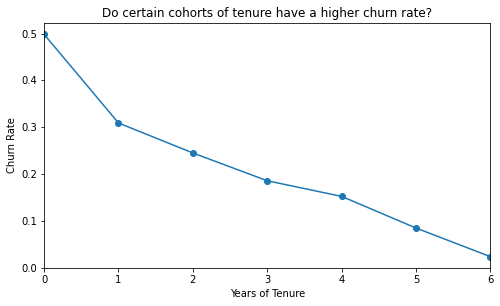

In [14]:
plt.figure(figsize=(8, 4.5))
train.groupby('tenure_years').churn_encoded.mean().plot(marker='o')
plt.xlabel('Years of Tenure')
plt.ylabel('Churn Rate')
plt.title('Do certain cohorts of tenure have a higher churn rate?')

We see here that the longer we have the customer, the less likely they are to churn.

### Next, we'll look at whether certain internet service types have higher rate of churn.

We will also use a $\chi^2$ contingency test to see if churn is independent of internet service type.

##### $\chi^2$ Test

$H_0$: Churn and internet service type are independent of each other.

$H_a$: Churn and internet service type are not independent of each other.

$\alpha$ = 0.05

In [15]:
churn_by_internet = pd.crosstab(train.internet_service_type, train.churn)

chi2_stat, p, degf, expected = stats.chi2_contingency(churn_by_internet)

alpha = 0.05

if p < alpha:
    print('p is less than alpha; Reject the null hypothesis')
    print(f'{p} < {alpha}')
else:
    print('p is greater than alpha; Fail to reject the null hypothesis')
    print(f'{p} > {alpha}')

p is less than alpha; Reject the null hypothesis
1.5429166415130964e-77 < 0.05


So we can reject the null hypothesis, so churn and internet service type are not independent of each other.

#### Let's look at a bar plot of the churn rate of each internet service type

Text(0, 0.5, 'Churn Rate')

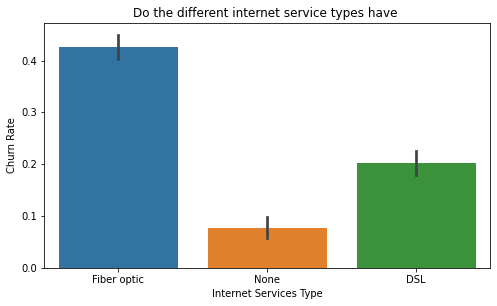

In [20]:
plt.figure(figsize=(8, 4.5))
sns.barplot(x=train.internet_service_type, y=train.churn_encoded)
plt.title('Do certain internet service types have different churn rates?')
plt.xlabel('Internet Service Type')
plt.ylabel('Churn Rate')

We can see that Fiber Optic customers are 4 times as likely to churn as those that don't have internt and twice as likely as those with DSL.

### Next, we'll look at whether certain phone service types have higher rate of churn.

We will also use a $\chi^2$ contingency test to see if churn is independent of phone service type.

##### $\chi^2$ Test

$H_0$: Churn and phone service type are independent of each other.

$H_a$: Churn and phone service type are not independent of each other.

$\alpha$ = 0.05

In [17]:
churn_by_phone = pd.crosstab(train.multiple_lines, train.churn)

chi2_stat, p, degf, expected = stats.chi2_contingency(churn_by_phone)

alpha = 0.05

if p < alpha:
    print('p is less than alpha; Reject the null hypothesis')
    print(f'{p} < {alpha}')
else:
    print('p is greater than alpha; Fail to reject the null hypothesis')
    print(f'{p} > {alpha}')

p is greater than alpha; Fail to reject the null hypothesis
0.05221646010738923 > 0.05


So we fail to reject the null hypothesis, so churn and phone service type are independent of each other.

#### Let's look at a bar plot of the churn rate of each phone service type

Text(0, 0.5, 'Churn Rate')

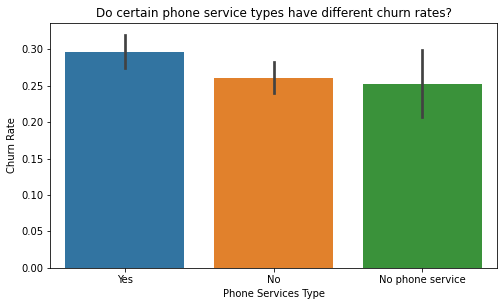

In [23]:
plt.figure(figsize=(8, 4.5))
sns.barplot(x=train.multiple_lines, y=train.churn_encoded)
plt.title('Do certain phone service types have different churn rates?')
plt.xlabel('Phone Service Type')
plt.ylabel('Churn Rate')

We can see that their are only minor differences between the three service types.

### Next, we'll look at whether senior citizens have higher rates of churn.

We will also use a $\chi^2$ contingency test to see if churn is independent being a senior citizen.

##### $\chi^2$ Test

$H_0$: Churn and being a senior citizen are independent of each other.

$H_a$: Churn and being a senior citizen are not independent of each other.

$\alpha$ = 0.05

In [33]:
churn_by_senior = pd.crosstab(train.senior_citizen, train.churn)

chi2_stat, p, degf, expected = stats.chi2_contingency(churn_by_senior)

alpha = 0.05

if p < alpha:
    print('p is less than alpha; Reject the null hypothesis')
    print(f'{p} < {alpha}')
else:
    print('p is greater than alpha; Fail to reject the null hypothesis')
    print(f'{p} > {alpha}')

p is less than alpha; Reject the null hypothesis
2.5903239105911664e-23 < 0.05


So we can reject the null hypothesis, so churn and being a senior citizen are not independent of each other.

#### Let's look at a bar plot of the churn rate whether someone is a senior citizen.

Text(0.5, 1.0, 'Are Senior Citizens more likely to churn?')

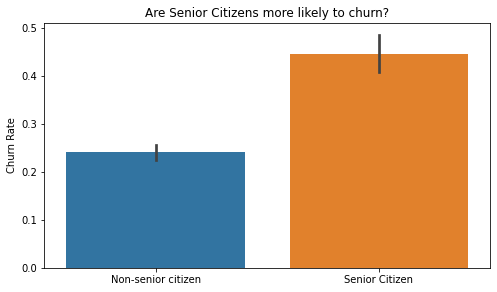

In [34]:
plt.figure(figsize=(8, 4.5))
sns.barplot(x=train.senior_citizen, y=train.churn_encoded)
plt.xticks(np.arange(0, 2), ['Non-senior citizen', 'Senior Citizen'])
plt.xlabel('')
plt.ylabel('Churn Rate')
plt.title('Are Senior Citizens more likely to churn?')

We can see that Senior Citizens are almost twice as likely to churn as non-senior citizens.